# Neural Networks: GPU training

So far, we trained all networks on the CPU. Unfortunately, this isn't a reasonable thing to do for large networks. In this tutorial, we will look at how to train a neural network on the GPU in order to speed-up training.

**Hint:** If do not have a GPU, I recommend using Google Colab. **Google Colab** hosted Jupyter Notebook service that requires no setup to use and provides free access to computing resources, including GPUs and TPUs.

## GPU/TPU-based training using Google Colab

If you decided to use Google Colab for running this notebook, the first thing to do is enable the TPU runtime support. To enable the TPU runtime support click on "Laufzeit -> Laufzeittyp ändern -> T4 GPU".

Once this flag is set, executing the next cell should indicate the environment in which the notebook is executed, does over a GPU.

In [64]:
! nvidia-smi

Sun Jan  7 12:36:44 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0              27W /  70W |    189MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Basic imports

In [65]:
from sklearn.datasets import fetch_california_housing
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import trange
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
from torch.optim import Adam
import torch.nn.functional as F
import random

In [66]:
# To ensure reproducability
np.random.seed(42)

In [67]:
def batch(iterable, n=1):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]

## Fetch the california housing dataset

In [68]:
dataset = fetch_california_housing(as_frame=True)

In [69]:
housing_df = dataset['data']
target_df = dataset['target']

In [70]:
# Insert the housing prices in the housing df
housing_df['HousePrice'] = target_df

### Preprocess the samples

## Prepare the training and testing set


### Splitting the dataframe (using sklearn)

In [71]:
train_df, test_df = train_test_split(housing_df, test_size=0.2)

In [72]:
# Briefly check whether we have the correct set sizes
print('Test ratio: ', len(test_df) / (len(train_df) + len(test_df)))

Test ratio:  0.2


In [73]:
feature_columns = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
target_column = 'HousePrice'

x_train = train_df[feature_columns].values
y_train = train_df[['HousePrice']].values

x_test = test_df[feature_columns].values
y_test = test_df[['HousePrice']].values

#### Standardize the input features

In this example, we will use Scikit's StandardScaler to standardized the input features. In future examples, we will start to use PyTorch's "on-board capabilities" to preprecess the input features (e.g., https://pytorch.org/vision/main/generated/torchvision.transforms.Normalize.html)

In [74]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

#### Convert all samples to a PyTorch tensor

In [75]:
x_train = torch.tensor(x_train, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)

y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

## Prepare the neural network


In [76]:
input_dims = len(feature_columns)
output_dims = 1

In [77]:
model = nn.Sequential(
    nn.Linear(input_dims, 512, bias=False),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Linear(512, 256, bias=False),
    nn.BatchNorm1d(256),
    nn.ReLU(),
    nn.Linear(256, 256, bias=False),
    nn.BatchNorm1d(256),
    nn.ReLU(),
    nn.Linear(256, 128, bias=False),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Linear(128, 1),
)

## Train the neural network on the GPU

In order to train a model on the GPU, all parameters/variables required during training (e.g., the model, the tensor) have to be copied to the GPU.

This can be done either by calling `.cuda()` or `.to(DEVICE)` on a tensor/model. I recommend using using `.to(DEVICE)` is allows us to conveniently switch between different devices by adjusting the `DEVICE` variable.

In [78]:
# Fix seed to ensure reproducibility
np.random.seed(42)
torch.manual_seed(0)

#### Helper function that computes for RMSE for a given dataset

The *evaluate_model_performance()* function receives a set of features and their target levels as its input, and evaluates the model performance using the root mean square error. In order to do this, the network must be switched to *inference mode* (`model.eval()`).

In [79]:
def evaluate_model_performance(x, y, batch_size=1024):

    assert x.shape[0] == y.shape[0], 'Feature and target labels a different number of samples'

    # During training, the batch norm layer keeps a running estimate of its computed mean and variance.
    # At inference time, the mean/variance must not be updated. The estimed mean/variance is used for normalization.
    model.eval()

    total_error = 0.

    num_samples = x.shape[0]

    # No gradient have to be computed at inference time. We can disable gradient computation by means of the
    # no_grad() context manager. This will reduce the memory consumption.
    with torch.no_grad():

        for indices in batch(range(num_samples), batch_size):

            # Convert the sample to a Pytorch tensor
            batch_x = x[indices]
            batch_y = y[indices]

            batch_x = batch_x.to(DEVICE)
            batch_y = batch_y.to(DEVICE)

            pred = model(batch_x)

            total_error += torch.sum((pred - batch_y) **2)

    rmse = torch.sqrt(total_error / num_samples) * 100000
    rmse = rmse.cpu().numpy()

    # Switch the network back to training mode since want to continue training.
    model.train()

    return rmse


#### Copy the model to the GPU

Before we start training, we copy the entire model to the GPU. This only needs to be done once.

In [80]:
DEVICE = 'cuda'

# Use "cpu" if we want to briefly switch back to CPU training
# DEVICE = 'cpu'

# Specify the device id, if our setup has multiple GPUs and we want to train on a specific GPU
# DEVICE = 'cuda:0'

# Copy the model to the GPU
model = model.to(DEVICE)

#### Start training

In [81]:
batch_size = 128
num_epochs = 300

In [82]:
# We will use the ADAM optimizer to find the "optimal" network weights.
# The ADAM optimization is a stochastic gradient descent method that is based on
# adaptive estimation of first-order and second-order moments.
optimizer = Adam(model.parameters(), lr=1e-6)

In [83]:
train_rmse = []

num_samples = x_train.shape[0]

for epoch in trange(num_epochs):

    # Samples should be drawn in random order.
    # Hence, we create a list of indices (in random order) from which we can sample from.
    shuffled_indices = list(range(num_samples))
    random.shuffle(shuffled_indices)

    batch_iter = batch(shuffled_indices, 128)

    for batch_idx, sample_indices in enumerate(batch_iter):

        # Clear all gradients
        optimizer.zero_grad()

        batch_x = x_train[sample_indices]
        batch_y = y_train[sample_indices]

        # IMPORTANT: We have to make sure that the batch is on the same devices the model
        batch_x = batch_x.to(DEVICE)
        batch_y = batch_y.to(DEVICE)

        # Push the training batch through the neural network
        pred = model(batch_x)

        # Compute the mean squared error --> Our goal is to minimize this error
        loss = F.mse_loss(pred, batch_y)

        # Trigger backpropagation. This computes all gradients that have to be optimized.
        loss.backward()

        # Update the weights based on the obtained gradient values
        optimizer.step()

        if batch_idx % 50 == 0:
            train_rmse.append(evaluate_model_performance(x_train, y_train))


100%|██████████| 300/300 [01:59<00:00,  2.51it/s]


Text(0.5, 1.0, 'Train RMSE')

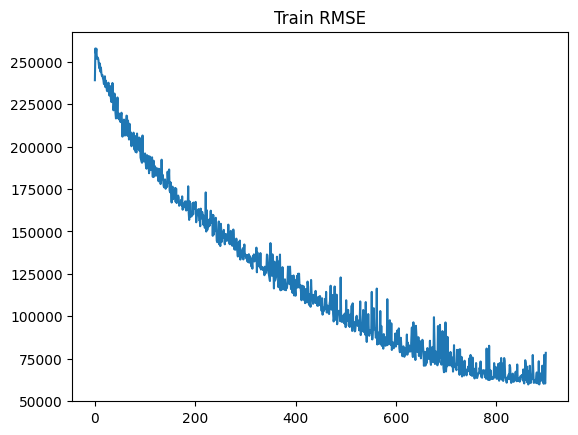

In [84]:
plt.plot(list(range(len(train_rmse))), train_rmse)
plt.title('Train RMSE')

## Performance evaluation

In [85]:
train_rmse = evaluate_model_performance(x_train, y_train)
test_rmse = evaluate_model_performance(x_test, y_test)

In [86]:
print('Train RMSE:', train_rmse)
print('Test RMSE:', test_rmse)

Train RMSE: 63533.46
Test RMSE: 63713.043


Congratz, you now trained your first model on the GPU!